# IMDB

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [11]:
!ls /home/ubuntu/.fastai/data

imdb_sample.tgz


In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

A new version of the dataset is available.



 Download of http://files.fast.ai/data/examples/imdb_sample.tgz has failed after 5 retries
 Fix the download manually:
$ mkdir -p /home/ubuntu/.fastai/data
$ cd /home/ubuntu/.fastai/data
$ wget -c http://files.fast.ai/data/examples/imdb_sample.tgz
$ tar -zxvf imdb_sample.tgz

And re-run your code once the download is successful



SystemExit: 1

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


It only contains one csv file, let's have a look at it.

In [8]:
from pathlib import Path

In [9]:
path=Path('/home/ubuntu/.fastai/data/imdb_sample')


In [24]:
#!cd /home/ubuntu/.fastai/data
!ls /home/ubuntu/.fastai/data

imdb_sample.tgz


In [14]:
! tar -zxvf imdb_sample.tgz

imdb_sample/
imdb_sample/texts.csv


In [18]:
! cd /home/ubuntu/.fastai

In [21]:
!ls
!mv imdb_sample .fastai/imdb_sample

Desktop    imdb_sample	    lesson3-imdb.ipynb	Proxy-SwitchyOmega_v2.5.20
Download   imdb_sample.tgz  MyFiles		user_space
Downloads  jupy.log	    proxy		未命名.ipynb


In [25]:
!sudo ls

Desktop    imdb_sample.tgz     MyFiles			   user_space
Download   jupy.log	       proxy			   未命名.ipynb
Downloads  lesson3-imdb.ipynb  Proxy-SwitchyOmega_v2.5.20


In [26]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb_sample/texts.csv')]

In [27]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [28]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [29]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [30]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [31]:
data.train_ds[0][0]

Text xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting schtick . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

But the underlying data is all numbers

In [32]:
data.train_ds[0][0].data[:10]

array([   2,    5, 6132,   24,    0,   24, 1072,   53,    5, 3791])

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [34]:
bs=48

Now let's grab the full dataset for what follows.

In [38]:
# path = untar_data(URLs.IMDB)
# path.ls()

path=Path('/home/ubuntu/.fastai/data/imdb')


In [39]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/neg'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/ubuntu/.fastai/data/imdb/train/pos')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.



This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [40]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [41]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [42]:
data_lm.show_batch()

idx,text
0,"toilet breaks so they had less of the film to watch , or lamenting the sheer tedium of this movie . i did n't think it was xxup that bad ( not "" up "" to xxmaj death in xxmaj venice standard for example ) but by the end i was wondering what point the film - maker was actually trying to make . xxmaj given that it was impossible"
1,"continuation of their species is one rife for comedy . xxmaj granted , making a credible horror out of this concept is a difficult task , as xxmaj species proved in 1995 , but the problem in xxmaj decoys is that nobody even seems to be trying . xxmaj the film gives us little in the way of clues as to how to respond . \n \n xxmaj furthering"
2,"out of time , out of place , but visually arresting and impossible to take for granted . xxmaj it 's this approach that makes the work the product of a master of direction -- it can be seen multiple times and every time a different perspective arises , and all one can be left with is with the notion that this is pure , ultra - modern cinema ."
3,"changing the past to affect the future may not be a new concept in film , but "" xxmaj frequency "" handles it deftly and with heart . xxmaj the acting is superb , and as far as i can tell the plot is nearly airtight . xxmaj it keeps you on your toes as the story twists in what feels like six directions at once and keeps you in"
4,"that there was not much else out . xxmaj lets just say , i hated it . i think xxmaj adam xxmaj sandler has an uneven resume , there are movies i like of his and there are some i just do nt care for . i have never actually hated one of his movies ( although i never saw xxmaj little xxmaj nicky , nor do i want to"


We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

返回language_model_learner实例

In [45]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [44]:
# !wget -c https://s3.amazonaws.com/fast-ai-modelzoo/wt103-fwd.tgz
# ! tar -zxvf wt103-fwd.tgz


--2020-03-05 20:46:58--  https://s3.amazonaws.com/fast-ai-modelzoo/wt103-fwd.tgz
正在解析主机 s3.amazonaws.com (s3.amazonaws.com)... 失败：未知的名称或服务。
wget: 无法解析主机地址 “s3.amazonaws.com”
tar (child): wt103-fwd.tgz：无法 open: 没有那个文件或目录
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


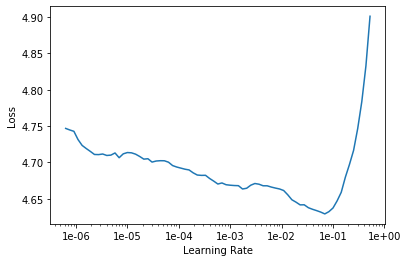

In [47]:
learn.recorder.plot(skip_end=15)

learn

param:
* epoch
* learning rate
* 1-Cycle style training的参数

In [48]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.152874,4.034433,0.294413,22:00


Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)"

In [51]:
learn.save('fit_head_yixue')

In [52]:
learn.load('fit_head_yixue')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos xxmaj well i just spent the evening watching this with a group of 7 friends , mostly high - school teachers , collectively our book & film club . xxmaj it started off quite positively - a bit bonkers perhaps but sort of amusing but by the end the audience was variously commenting : " i 'd have preferred having needles stuck in my eyes ! " or extending toilet breaks so they had less of the film to watch , or lamenting the sheer tedium of this movie . i did n't think it was xxup that bad ( not " up " to xxmaj death in xxmaj venice standard for example ) but by the end i was wondering what point the film - maker was actually trying to make . xxmaj given that it was impossible to have much sympathy for any of the characters and given that nothing actually happened , surely there must be a philosophical point to it all ? xxmaj once i realised there was none , i realised we had been yet again tricked in

第二次训练

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [54]:
learn.unfreeze()

In [55]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.848787,3.822900,0.316899,24:39


KeyboardInterrupt: 

In [ ]:
learn.save('fine_tuned_yixue2')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned_yixue2');

In [56]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [57]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because the premise is so original . i love it , Carter was n't a great movie , but in a way it has a good script , wonderful acting , and Madsen 's performance is beautiful .
I liked this movie because it was a well made , well done , well acted and well acted but still well - acted movie . My only complaint has the camera quality . There is no way that it has any eerie


我们只要encoder部分

We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

learn应该是LanguageLearner(RNNLearner)，RNNLearner子类，check一下

In [58]:
type(learn)

fastai.text.learner.LanguageLearner

In [59]:
learn.save_encoder('fine_tuned_enc')

## Classifier

这个时候我们只用训练数据，不像上面用了test数据

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [60]:
path = untar_data(URLs.IMDB)

用test数据代替validation数据？？？？

In [61]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [62]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [63]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the historical setting of the xxmaj titanic . xxmaj the plot is simple , xxunk , or not for those who love plots that twist and turn and keep you in suspense . xxmaj the end of the movie can be figured out within minutes of the start of the film , but the love",pos
"xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n \n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older",neg
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of oatmeal . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",neg
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos


在前面语言模型的基础上，扩展成一个分类模型

We can then create a model to classify those reviews and load the encoder we saved before.

In [65]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


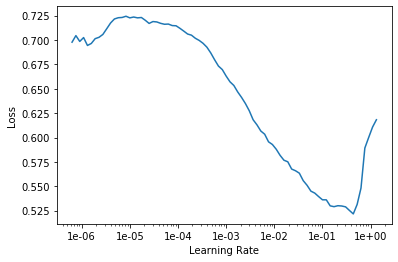

In [67]:
learn.recorder.plot()

In [68]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.338775,0.259830,0.895640,02:42


In [72]:
learn.save('classifier_first')

In [73]:
learn.load('classifier_first');

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:326: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


解冻后面的第二层，还是后两层

In [83]:
learn.bs

AttributeError: 'RNNLearner' object has no attribute 'bs'

In [82]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

RuntimeError: you can only change requires_grad flags of leaf variables.

In [75]:
learn.save('classifier_second')

In [76]:
learn.load('classifier_second');

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:326: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


解冻后三层？

In [79]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

RuntimeError: you can only change requires_grad flags of leaf variables.

In [ ]:
learn.save('classifier_third')

In [ ]:
learn.load('classifier_third');

全部解冻，再训练一次

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [80]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0026, 0.9974]))